In [1]:
%pip install agentpy 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Model Design
import agentpy as ap 
import numpy as np 
import pandas as pd
from boids_model import BoidsModel

# Visualisation
from visualisation import animation_plot, animation_plot_single
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import ast

In [3]:
# results = ap.DataDict.load(exp_name='BoidsModel', exp_id=4)
results = pd.read_csv('boids_statistics_results.csv')

In [4]:
def process_data(X, Y, batch_size=64, normalize=True, state=False):
    # Split the data into training+validation set and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Convert pandas dataframes to numpy arrays (if not already in numpy format)
    X_train_np, Y_train_np = X_train.values, Y_train.values
    X_test_np, Y_test_np = X_test.values, Y_test.values

    if normalize:
        # Initialize scalers for X and Y
        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()

        # Fit and transform the training data
        X_train, Y_train= scaler_X.fit_transform(X_train_np), scaler_Y.fit_transform(Y_train_np)
        # Transform the validation and test data
        X_test, Y_test = scaler_X.transform(X_test_np), scaler_Y.transform(Y_test_np)

    
    # Convert the numpy arrays back to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.float32)
    
    # Create TensorDataset objects
    train_dataset = TensorDataset(X_train, Y_train)
    test_dataset = TensorDataset(X_test, Y_test)

    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [48]:
# output_parameters = ['final_alignment', 'cohesion_separation_ratio', 'flock_density']
output_parameters = ['final_alignment']
# knobs = ['cohesion_strength', 'seperation_strength', 'alignment_strength', 'border_strength']
knobs = ['cohesion_strength', 'alignment_strength', 'border_strength']

# Y = results.reporters[output_parameters]
# X =  results.reporters[knobs]
Y = results[output_parameters]
X =  results[knobs]

train_loader, test_loader = process_data(X, Y, batch_size=64, normalize=True)

In [ ]:
print(X['seperation_strength'].value_counts())

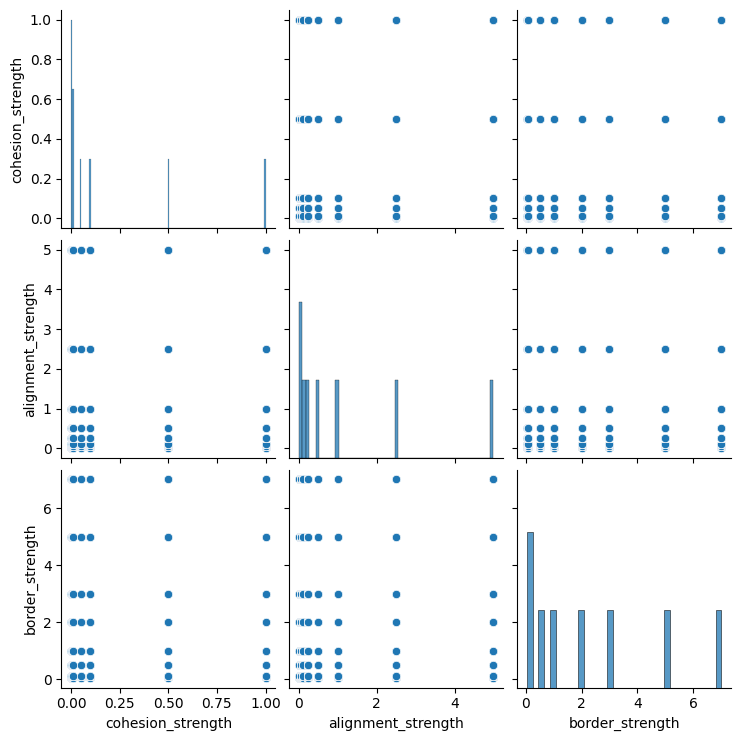

In [21]:
sns.pairplot(X)

In [22]:
correlation_matrix = X.corr()
print(correlation_matrix)

                    cohesion_strength  alignment_strength  border_strength
cohesion_strength        1.000000e+00        5.286253e-16     2.704745e-15
alignment_strength       5.286253e-16        1.000000e+00     1.056639e-17
border_strength          2.704745e-15        1.056639e-17     1.000000e+00


In [23]:
# Neural Network Architecture
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Input layer to 128 neurons
        self.fc2 = nn.Linear(128, 64)         # Hidden layer (128 to 64 neurons)
        self.fc3 = nn.Linear(64, 32)   # Hidden layer (64 to 32 neurons)
        self.fc4 = nn.Linear(32, output_size)   # Output layer (32 to number of target features)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function in the output layer
        return x

In [46]:
class SuperEnhancedNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SuperEnhancedNet, self).__init__()
        # Significantly increase the capacity of the network
        self.fc1 = nn.Linear(input_size, 1024)  # Input layer to 1024 neurons
        self.bn1 = nn.BatchNorm1d(1024)        # Batch normalization layer
        self.fc2 = nn.Linear(1024, 512)        # First hidden layer
        self.bn2 = nn.BatchNorm1d(512)         # Batch normalization layer
        self.fc3 = nn.Linear(512, 512)         # Second hidden layer
        self.dropout1 = nn.Dropout(0.5)        # Dropout layer for regularization
        self.fc4 = nn.Linear(512, 256)         # Third hidden layer
        self.bn3 = nn.BatchNorm1d(256)         # Batch normalization layer
        self.fc5 = nn.Linear(256, 256)         # Fourth hidden layer
        self.dropout2 = nn.Dropout(0.5)        # Another dropout layer
        self.fc6 = nn.Linear(256, 128)         # Fifth hidden layer
        self.bn4 = nn.BatchNorm1d(128)         # Batch normalization layer
        self.fc7 = nn.Linear(128, 64)          # Sixth hidden layer
        self.fc8 = nn.Linear(64, output_size)    # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout1(x)
        x = F.relu(self.fc4(x))
        x = self.bn3(x)
        x = F.relu(self.fc5(x))
        x = self.dropout2(x)
        x = F.relu(self.fc6(x))
        x = self.bn4(x)
        x = F.relu(self.fc7(x))
        x = self.fc8(x)  # No activation function in the output layer
        return x

In [35]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  
        self.fc2 = nn.Linear(1024, 512)         
        self.fc3 = nn.Linear(512, 256)  
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, output_size)   # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)  # No activation function in the output layer
        return x

In [49]:
input_size = X.shape[1]
output_size = Y.shape[1]
model = SuperEnhancedNet(input_size, output_size)

# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
for epoch in range(1000):  # Number of epochs
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()   # Zero the gradient buffers
        output = model(inputs)  # Pass the batch through the network
        loss = criterion(output, labels)  # Compute the loss
        loss.backward()         # Backpropagation
        optimizer.step()        # Update weights

        running_loss += loss.item()

        # Print average loss every 100 epochs
        if epoch % 100 == 0 and i == len(train_loader) - 1:
            print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')
            running_loss = 0.0

# Evaluate the model with test data (if available)

Epoch 1, Loss: 0.6599209308624268
Epoch 101, Loss: 0.3320554196834564
Epoch 201, Loss: 0.3230145573616028
Epoch 301, Loss: 0.31781670451164246
Epoch 401, Loss: 0.32233044505119324
Epoch 501, Loss: 0.3173293471336365
Epoch 601, Loss: 0.31507235765457153
Epoch 701, Loss: 0.3200729489326477
Epoch 801, Loss: 0.3147382438182831
Epoch 901, Loss: 0.31452682614326477
Epoch 1001, Loss: 0.3134719729423523
Epoch 1101, Loss: 0.3118191361427307
Epoch 1201, Loss: 0.3121277093887329
Epoch 1301, Loss: 0.3135271966457367
Epoch 1401, Loss: 0.31789466738700867
Epoch 1501, Loss: 0.3083916902542114
Epoch 1601, Loss: 0.3192580044269562


KeyboardInterrupt: 

In [42]:
# Assuming 'model' is your trained model and 'loss_fn' is your loss function
model.eval()  # Set the model to evaluation mode

total_loss = 0.0
total_samples = 0

with torch.no_grad():  # Do not calculate gradients to save memory
    for inputs, labels in test_loader:
        # Calculate the predictions for the current batch
        outputs = model(inputs)

        # Calculate the loss for the current batch
        loss = criterion(outputs, labels)
        
        # Aggregate the loss
        total_loss += loss.item() * inputs.size(0)  # Multiply by batch size to get total loss for this batch
        total_samples += inputs.size(0)

# Calculate average loss over all samples
average_loss = total_loss / total_samples

print(f'Test loss: {average_loss}')

Test loss: 0.25253593921661377


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Ensure model is in evaluation mode
model.eval()

# Initialize lists to store predictions and actual values
all_preds = []
all_true = []

with torch.no_grad():  # Ensure no gradients are calculated
    for inputs, labels in test_loader:  # Iterate over batches from the test DataLoader
        # Generate predictions
        outputs = model(inputs)
        
        # Store predictions and true values
        all_preds.extend(outputs.detach().cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# Convert lists to NumPy arrays for evaluation
all_preds_np = np.array(all_preds)
all_true_np = np.array(all_true)

# Calculate the metrics
mae = mean_absolute_error(all_true_np, all_preds_np)
mse = mean_squared_error(all_true_np, all_preds_np)
r2 = r2_score(all_true_np, all_preds_np)

print(f'MAE: {mae}, MSE: {mse}, R^2: {r2}')


MAE: 0.25253596901893616, MSE: 0.3819383382797241, R^2: 0.621300161535227


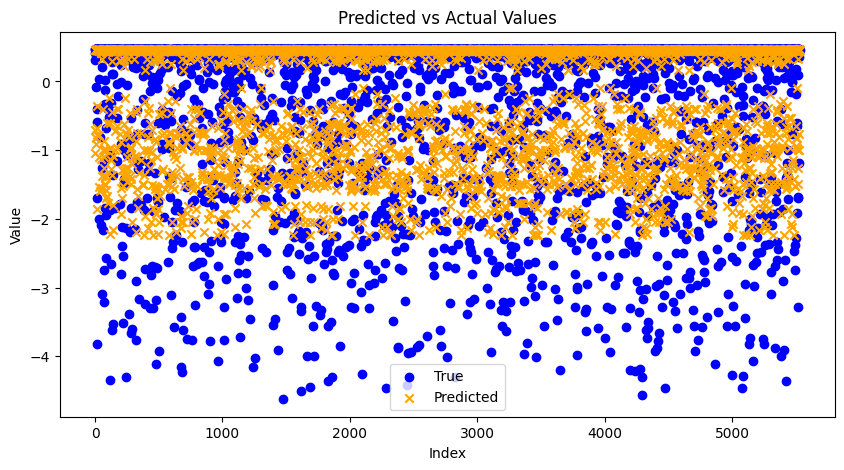

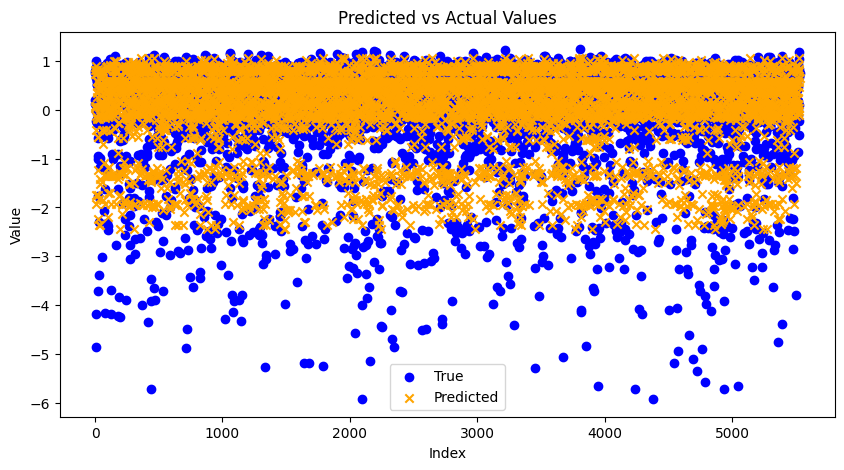

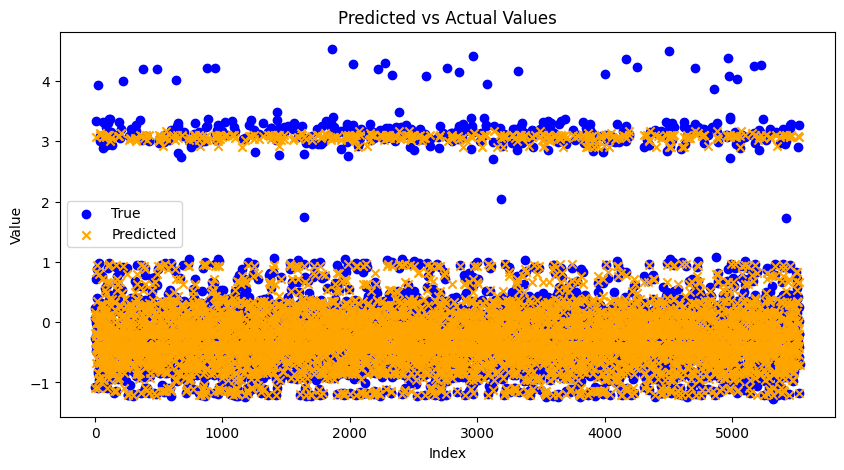

In [44]:
# Assuming Y_test_np and Y_pred_np are 2D arrays with 4 columns each
for i in range(all_true_np.shape[1]):
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(all_true_np[:, i])), all_true_np[:, i], color='blue', label='True')
    plt.scatter(range(len(all_preds_np[:, i])), all_preds_np[:, i], color='orange', label='Predicted', marker='x')
    plt.title('Predicted vs Actual Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

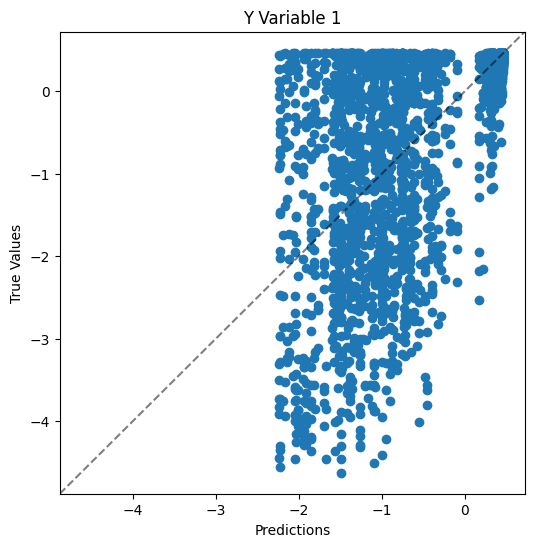

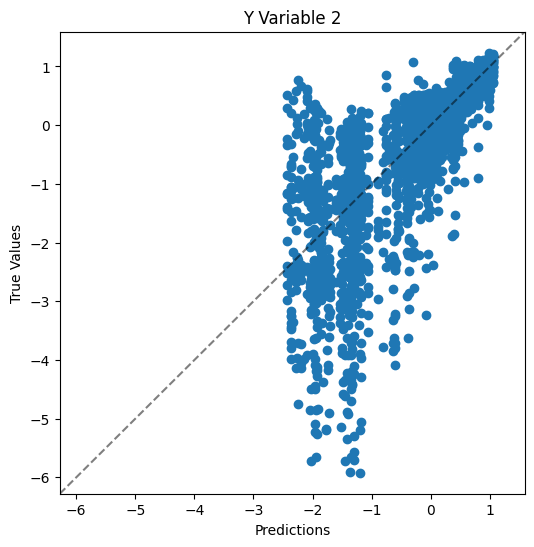

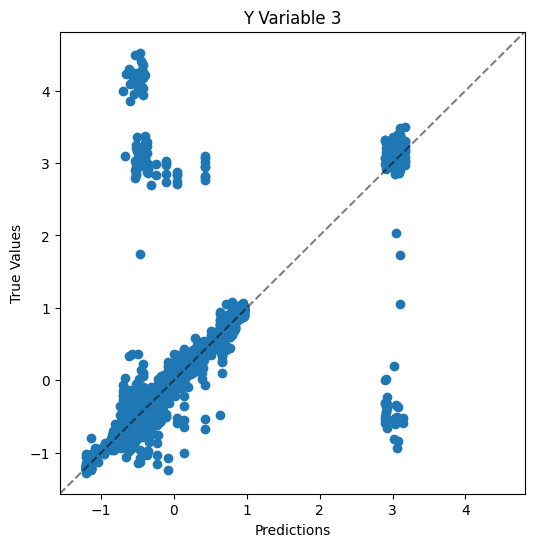

In [45]:
# Assuming Y_test_np and Y_pred_np are 2D arrays with 4 columns each
for i in range(all_true_np.shape[1]):
    plt.figure(figsize=(6, 6))
    plt.scatter(all_preds_np[:, i], all_true_np[:, i])
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title(f'Y Variable {i+1}')

    # Add a diagonal line
    limits = [np.min([plt.xlim(), plt.ylim()]),  # Find the lower limit
              np.max([plt.xlim(), plt.ylim()])]  # Find the upper limit
    plt.xlim(limits)
    plt.ylim(limits)
    plt.plot(limits, limits, color='black', alpha=0.5, linestyle='--')

    plt.show()